## **Setup Environment & Run Packages**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

#split data
from sklearn.model_selection import train_test_split

#create pipeline
from sklearn.pipeline import Pipeline

#ML
from pycaret.classification import *

## **Load Data**

In [2]:
df = pd.read_csv('../dataset/CheckPoints/Cleaned_df.csv')

## **Split Data**

First, we must make sure about the balance of the data.

In [3]:
df['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

As we can see, we have an imbalanced dataset. So, we should consider it during spliting. We split dataset to train and evaluate. We use train for building and testing the model and then we use evaluat set to behave as unseen data to run final model.

In [4]:
train_set, evaluate_set = train_test_split(df, test_size = 0.1, stratify = df['Churn'], random_state = 42)

In [5]:
print('train ~ No:' , train_set['Churn'].value_counts()[0]/train_set.shape[0])
print('train ~ Yes:' , train_set['Churn'].value_counts()[1]/train_set.shape[0])
print('evaluate ~ No:' , evaluate_set['Churn'].value_counts()[0]/evaluate_set.shape[0])
print('evaluate ~ Yes:' , evaluate_set['Churn'].value_counts()[1]/evaluate_set.shape[0])

train ~ No: 0.734197218710493
train ~ Yes: 0.26580278128950696
evaluate ~ No: 0.734375
evaluate ~ Yes: 0.265625


From now on, we work on train_set data.

## **Build Model**

To begin with, we should declare all features based on their type.

In [6]:
num_f = ['tenure', 'MonthlyCharges', 'TotalCharges',]

cat_f = ['Dependents', 'MultipleLines', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'PaperlessBilling', 'gender', 'InternetService',
       'Contract', 'PaymentMethod', 'SeniorCitizen']

ign_f = ['customerID']

> ### **Seupt Model Experiment**

In [27]:
exp = setup(
    #Model Selection
    data = train_set,    
    target = 'Churn',   
    train_size = 0.8,    
    fold = 10,    
    session_id = 42,
    
    #Data Types
    numeric_features = num_f,    
    categorical_features = cat_f,    
    ignore_features = ign_f,
    #ordinal_features
    
    #configuration
    bin_numeric_features = ['MonthlyCharges', 'TotalCharges'],
    normalize = True,
    transformation = True, 
    #transform_target = True - just regression
    feature_selection = True,
    remove_outliers = True,
    remove_multicollinearity = True,
    fix_imbalance = True,
    pca = True, 
    experiment_name = "customer-churn-prediction")

,Description,Value
0,Session id,42
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(6328, 19)"
5,Transformed data shape,"(8240, 4)"
6,Transformed train set shape,"(6974, 4)"
7,Transformed test set shape,"(1266, 4)"
8,Ignore features,1
9,Ordinal features,11


>### **Build Model**

Now we build many models and compare a metric for the bests. The models are sorted by F1 Score due Precision and Recall are importants for the evaluation. The cross-validation is made with 5-folds.

In [28]:
top_model = compare_models(fold = 5, sort = "F1", n_select = 1, exclude = ["catboost"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7533,0.0000,0.8015,0.5235,0.6333,0.4595,0.4832,0.8860
lr,Logistic Regression,0.7596,0.8416,0.7762,0.5325,0.6316,0.4622,0.4804,0.7920
lda,Linear Discriminant Analysis,0.7539,0.8406,0.7814,0.5254,0.6279,0.4545,0.4749,0.8040
ada,Ada Boost Classifier,0.7572,0.8303,0.7643,0.5299,0.6258,0.4547,0.4716,0.9780
svm,SVM - Linear Kernel,0.7517,0.0000,0.7784,0.5250,0.6248,0.4505,0.4725,0.7720
gbc,Gradient Boosting Classifier,0.7594,0.8354,0.7457,0.5339,0.6221,0.4526,0.4664,1.0180
lightgbm,Light Gradient Boosting Machine,0.7588,0.8212,0.6974,0.5357,0.6052,0.4359,0.4446,0.8120
et,Extra Trees Classifier,0.7523,0.7952,0.6639,0.5278,0.5872,0.4138,0.4201,1.0840
rf,Random Forest Classifier,0.7384,0.8034,0.6803,0.5058,0.5801,0.3961,0.4054,1.1540
knn,K Neighbors Classifier,0.7390,0.7846,0.6714,0.5068,0.5771,0.3938,0.4024,0.9960


Processing:   0%|          | 0/57 [00:00<?, ?it/s]

The best model is the **Linear Discriminant Analysis**, with a F1 Score around **0.6328**. 

>### **Tune Model**

Now, it's time to tune the model. 

In [10]:
tuned_model = tune_model(estimator = top_model, 
                         fold = 5,
                         optimize = "F1", 
                         choose_better = True,
                         verbose = False)

tuned_model

LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=None, solver='svd',
                           store_covariance=False, tol=0.0001)

We also, try to bag (boost) the model to see whether can we improve the F1 or not.

In [12]:
boosted_model = ensemble_model(tuned_model, 
                              fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7601,0.8315,0.7546,0.5342,0.6256,0.4566,0.4714
1,0.7522,0.8424,0.7881,0.5222,0.6281,0.4536,0.4752
2,0.7559,0.8425,0.8141,0.5264,0.6394,0.4675,0.4929
3,0.7717,0.8512,0.7732,0.5503,0.6430,0.4821,0.4972
4,0.7322,0.8185,0.7732,0.4976,0.6055,0.4169,0.4402
Mean,0.7544,0.8372,0.7807,0.5261,0.6283,0.4553,0.4754
Std,0.0129,0.0113,0.0198,0.0172,0.0131,0.0217,0.0202


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

We could not improve the F1. Now, we can try for blend the model.

In [15]:
blended_model = blend_models(estimator_list = [tuned_model, boosted_model],
                            fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7493,0.8387,0.7770,0.5186,0.6220,0.4454,0.4658
1,0.7552,0.8452,0.7844,0.5262,0.6299,0.4574,0.4777
2,0.7520,0.8415,0.8104,0.5215,0.6346,0.4600,0.4856
3,0.7648,0.8618,0.8327,0.5372,0.6531,0.4874,0.5142
4,0.7421,0.8102,0.6617,0.5115,0.5770,0.3958,0.4026
Mean,0.7527,0.8395,0.7732,0.5230,0.6233,0.4492,0.4692
Std,0.0075,0.0167,0.0592,0.0085,0.0253,0.0300,0.0369


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

We could not improve the F1.

>### **Declare Best Model**

The best model is the **tuned_model**.

In [16]:
best_model = tuned_model
print(f"Model: {type(best_model)}")

Model: <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>


## **Test Model**

The test is made with the remaining 30% of data that we got on the setup, it's important to see that the model is not overfitting.

In [17]:
predict_model(best_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.7551,0.8281,0.7656,0.5276,0.6247,0.4520,0.4692


## **Analyse Model**

Now, we can analyze the performance of model.

> ### **Learning Curve**

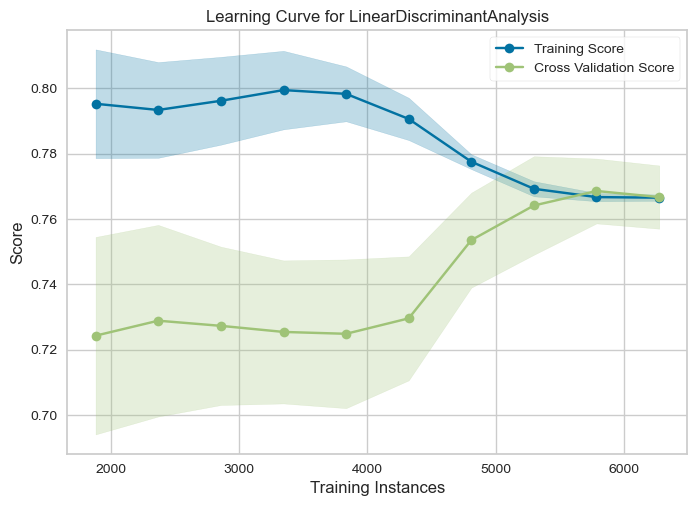

In [18]:
plot_model(best_model, plot = 'learning')

A Learning Curve plot is a graphical representation of the training and validation performance of a model as a function of the number of training samples. It is a useful way to understand the bias-variance tradeoff of a model and to identify whether the model is underfitting or overfitting the data. The validation score increases with the number of training samples but eventually reaches a plateau, indicating that the model is not overfitting the data. The gap between the training (blue) (**0.7523**) and validation scores (green) (**0.7551**) is becoming small and stable, and finally they reached together.

> ### **ROC / AUC Curve**

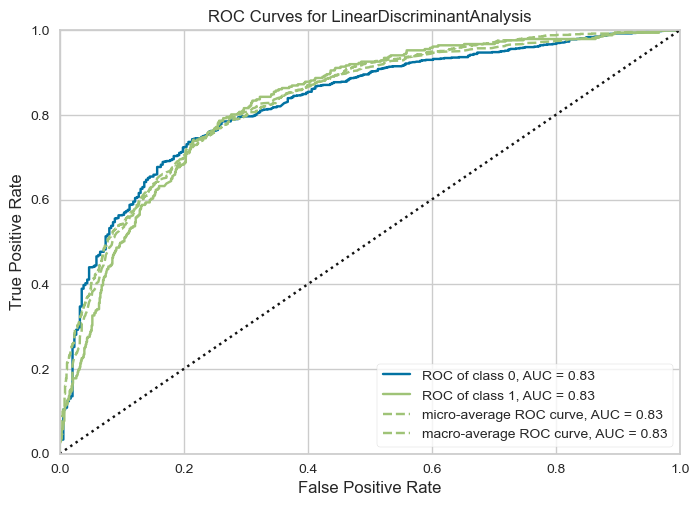

In [19]:
plot_model(best_model, plot = "auc")

The AUC is a metric that measures the overall performance of a model in distinguishing between positive and negative samples. The curve shows how the TPR and FPR change at different classification thresholds. A model with a higher AUC value generally indicates better discrimination and performance. A perfect model would have an AUC of 1.0, indicating that it can perfectly separate positive and negative instances. On the other hand, a model with an AUC of 0.5 implies that its predictions are no better than random guessing.

> ### **Classification Report**

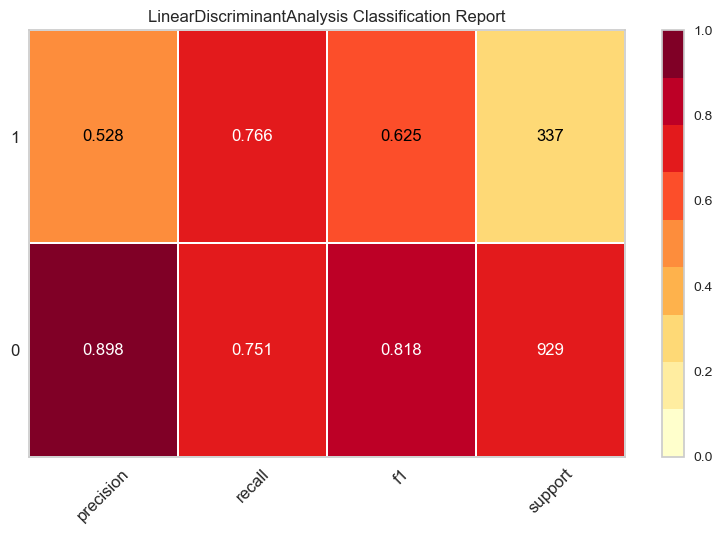

In [20]:
plot_model(best_model, plot="class_report")

The model has done a good work on the metrics for the class 0 (Not Churned) but got a Precision close to 0.52 for class 1 (Churned).

## **Finalize Model**

In [21]:
final_model = finalize_model(best_model)

In [24]:
final_model 

Pipeline(memory=FastMemory(location=C:\Users\Mehrdad\AppData\Local\Temp\joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['tenure', 'MonthlyCharges',
                                             'TotalCharges'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,...
                                                                                         reg_lambda=0.0,
                                                                                         silent='warn',
                                                                                         subsample=1.0,
                                                                                         subsample_for_bin=200000,
                                                                                         subsample_freq=0),
                                                                importance_getter='auto',
                                                                max_features=3,
                                                                norm_order=1,
                                                                prefit=False,
                                                                threshold=-inf))),
                ('actual_estimator',
                 LinearDiscriminantAnalysis(covariance_estimator=None,
                                            n_components=None, priors=None,
                                            shrinkage=None, solver='svd',
                                            store_covariance=False,
                                            tol=0.0001))],
         verbose=False)

## **Predict Evaluate Data by Model**

The remaining 10% data is used to make predictions with unseen samples (evaluate).
This data include some outliers and it's how real world data works.
It's not necessary to make any transformation on the data, because the model that we built does it.

In [22]:
predict_unseen = predict_model(final_model, data = evaluate_set);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.7386,0.8100,0.7433,0.5055,0.6017,0.4175,0.4348


The unseen data is predicted with accuracy close to train and test accuracy.

## **Save Model**

Finally, we save the model for delivering to deployment team.

In [23]:
model_path = "../dataset/Model/ChurnPredictionModel"

save_model(final_model, model_path)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\Mehrdad\AppData\Local\Temp\joblib),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['tenure', 'MonthlyCharges',
                                              'TotalCharges'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,...
                                                                                          reg_lambda=0.0,
                                                                                          silent='warn',
                                                                                          subsample=1.0,
                        